#Final project Antoine MOUSTER 
#Calculator using Image detection and classification

#Libraries and data import

In [1]:
# Connect to goole drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# import libraries
import cv2
import os
import numpy as np
import glob
from matplotlib import pyplot as plt
import random
import seaborn as sn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imutils
from imutils.contours import sort_contours
import skimage
from skimage import transform
from PIL import Image
from skimage.feature import hog
from skimage.transform import resize

In [3]:
DATA_DIR = '/content/gdrive/My Drive/LSMA_Final_Project/'

#Pictures and labels acquisition

Obtention of the labels list :

In [4]:
names = np.array(list(os.listdir(DATA_DIR)))
names = np.sort(names)
names = np.delete(names,10)

print(names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'div' 'minus' 'plus' 'times']


Getting link between the label and the label index :

(The CNN cannot use "div", "minus", "plus" and "times" as output)

In [5]:
idx_to_name = {i:x for (i,x) in enumerate(names)}
name_to_idx = {x:i for (i,x) in enumerate(names)}

Loop over directory to get the data & labels and resize images (45,45)

In [6]:
# Loop over dir to get the data & labels and resize images (45,45)
data = []
labels = []
for i in names :
  imgs =   [cv2.resize(cv2.imread(img), (45,45), interpolation=cv2.INTER_AREA) for img in glob.glob(DATA_DIR + i + "/*")]
  for img in imgs:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(gray_img)
    labels.append(name_to_idx[i])

In [7]:
# Check data is correctly imported
print(np.shape(data))

(20054, 45, 45)


#Images pre-processing for CNN

Split the data into training and testing dataset :

In [8]:
# split the data
data_train, data_test, labels_train, labels_test = train_test_split(data, labels)

Normalizing the images :

In [9]:
# Normalize the data
data_train = np.array(data_train)
data_train = data_train/255.0

data_test = np.array(data_test)
data_test = data_test/255.0

#EDA

Plot some random samples from differents classes :

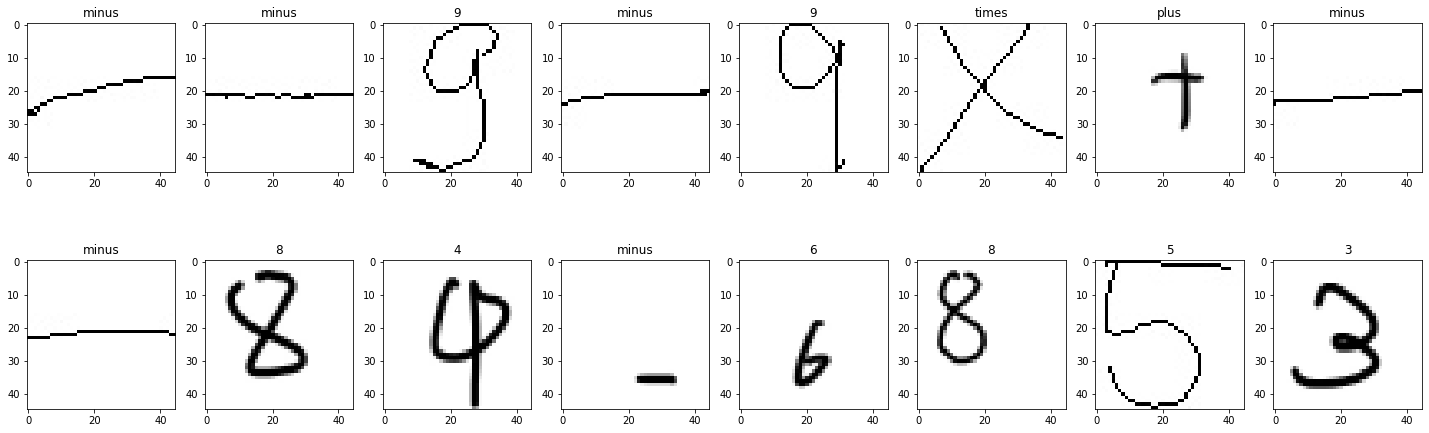

In [10]:
# Plot several samples of the dataset
fig,ax = plt.subplots(2,8,figsize = (25,8))
ax = ax.ravel()
for i in range(16):
  rand = np.random.randint(0,np.shape(data)[0])
  image = data[rand]
  ax[i].imshow(image,cmap = 'gray')
  ax[i].set_title(idx_to_name[labels[rand]])
  
plt.show()

Plot some random samples from the same class :

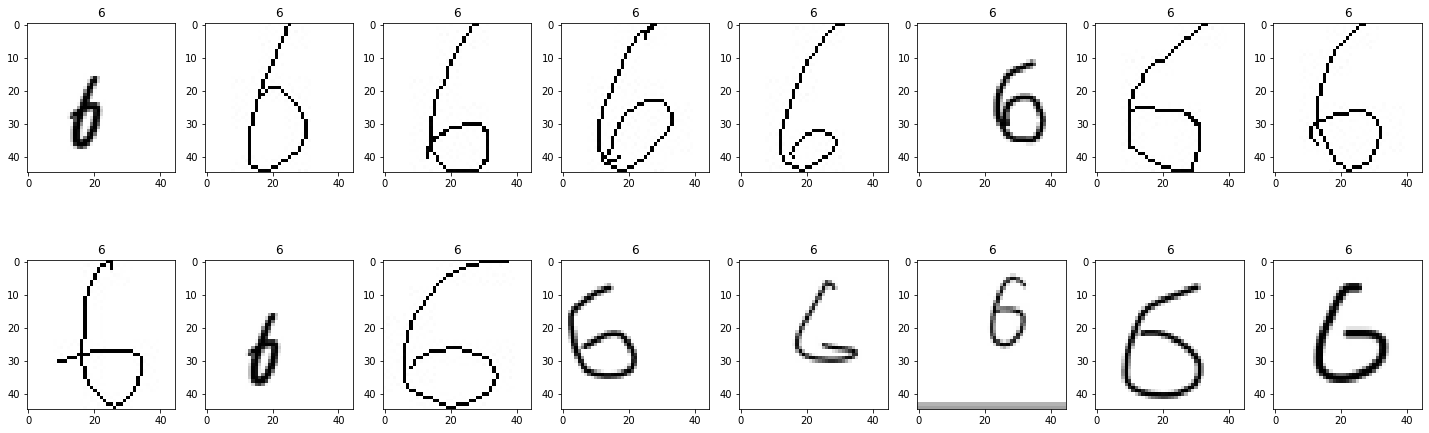

In [11]:
# Plot several samples of one class of the dataset (here 16 pictures '1')

fig,ax = plt.subplots(2,8,figsize = (25,8))
ax = ax.ravel()
for i in range(16):
  index = random.randint(9090, 10671)
  image = data[index]
  ax[i].imshow(image,cmap = 'gray')
  ax[i].set_title('6')
  
plt.show()

Bar graph of the repartition of our data :

We can see we have very few div samples


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


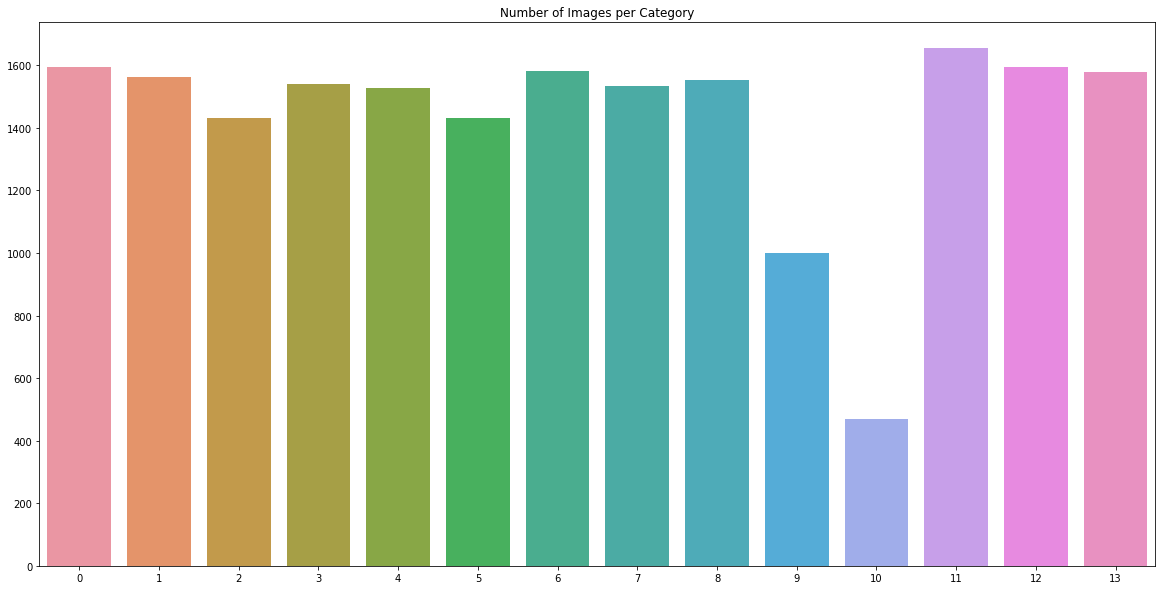

In [12]:
# number  of samples per class

unique, count = np.unique(labels, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique, count).set_title('Number of Images per Category')
plt.show()

Bar graph of the repartition of the training dataset :

(Follows the same tendency as the previous one)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


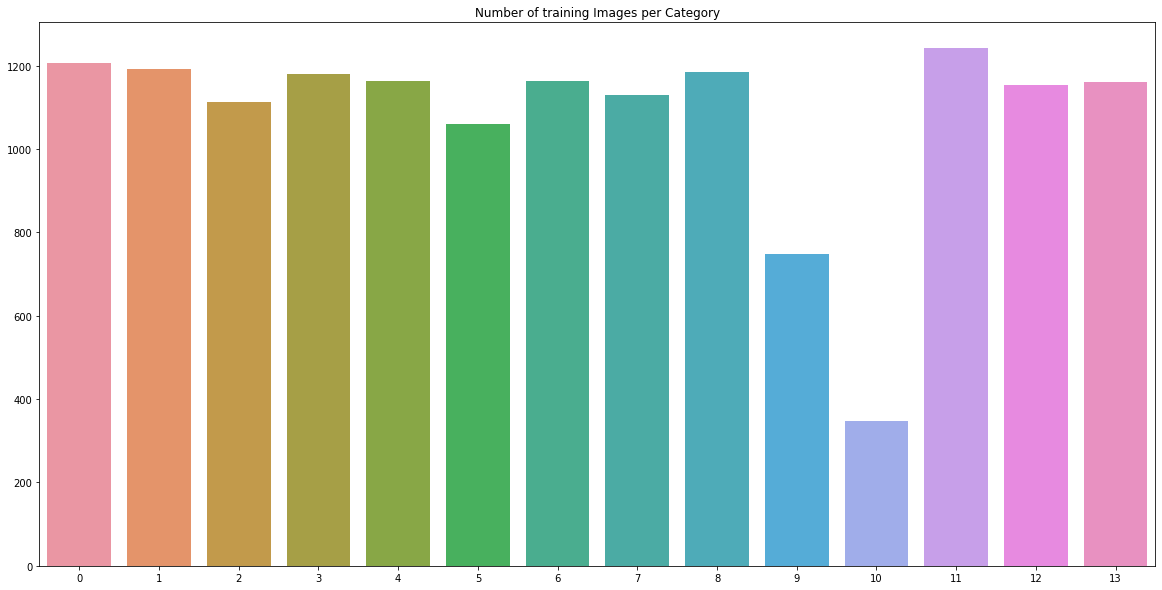

In [13]:
# number of training  samples per class

unique, count = np.unique(labels_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique, count).set_title('Number of training Images per Category')
plt.show()

#Transforming the labels for CNN

In [14]:
# Transform label vector into an "identity matrix'"
def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [15]:
# Transform the labels
labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)

In [16]:
# check it has been transformed 
print(labels_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


#HOG feature extraction

Obtenting of the range of index for each digits and symbols :

In [17]:
count = []
count.append(0)
for i in range(14):
  count.append(labels.count(i)+count[i])  
print(count)

[0, 1595, 3157, 4590, 6131, 7657, 9090, 10671, 12204, 13758, 14758, 15226, 16881, 18477, 20054]


Storage of the HOG feature vector of each sample (same order as index) :

In [18]:
hog_features = []
for i in range(len(data)-1):
  fd, hog_image = hog(data[i], orientations=9, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
  hog_features.append(fd)
  

Function that determine the label of the HOG test feature vector

In [19]:
def test_hog(im_to_test):
  fd, hog_image = hog(im_to_test, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
  somme = 0
  test_somme = 0
  index=0
  #We loop on each HOG feature vector of all our data
  for i in range(len(hog_features)):
    #We compute the difference between the HOG vector test sample and the HOG vector for each data
    soustraction = abs(hog_features[i]-fd)
    test_somme = sum(soustraction) 
    if somme == 0:
      somme = test_somme
      index = i
      #If the sum is lower than the previous stored we store it (keep the closest)
    else : 
      if test_somme < somme :
        somme = test_somme
        index = i
  #We find the label
  if count[0] <= index < count[1] :
    return 0
  if count[1] <= index < count[2] :
    return 1
  if count[2] <= index < count[3] :
    return 2
  if count[3] <= index < count[4] :
    return 3 
  if count[4] <= index < count[5] :
    return 4
  if count[5] <= index < count[6] :
    return 5
  if count[6] <= index < count[7] :
    return 6 
  if count[7] <= index < count[8] :
    return 7
  if count[8] <= index < count[9] :
    return 8
  if count[9] <= index < count[10] :
    return 9
  if count[10] <= index < count[11] :
    return 10
  if count[11] <= index < count[12] :
    return 11
  if count[12] <= index < count[13] :
    return 12
  if count[13] <= index < count[14] :
    return 13
  if count[14] <= index < count[15] :
    return 14

In [20]:
list_test_0 = []
list_test_1 = []
list_test_2 = []
list_test_3 = []
list_test_4 = []
list_test_5 = []
list_test_6 = []
list_test_7 = []
list_test_8 = []
list_test_9 = []
list_test_10 = []
list_test_11 = []
list_test_12 = []
list_test_13 = []

for i in range(100):
  print(i)
  list_test_0.append(test_hog(data[i]))
  list_test_1.append(test_hog(data[i+count[1]]))
  list_test_2.append(test_hog(data[i+count[2]]))
  list_test_3.append(test_hog(data[i+count[3]]))
  list_test_4.append(test_hog(data[i+count[4]]))
  list_test_5.append(test_hog(data[i+count[5]]))
  list_test_6.append(test_hog(data[i+count[6]]))
  list_test_7.append(test_hog(data[i+count[7]]))
  list_test_8.append(test_hog(data[i+count[8]]))
  list_test_9.append(test_hog(data[i+count[9]]))
  list_test_10.append(test_hog(data[i+count[10]]))
  list_test_11.append(test_hog(data[i+count[11]]))
  list_test_12.append(test_hog(data[i+count[12]]))
  list_test_13.append(test_hog(data[i+count[13]]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [21]:
test_sum = list_test_0.count(0)+list_test_1.count(1)+list_test_2.count(2)+list_test_3.count(3)+list_test_4.count(4)+list_test_5.count(5)+list_test_6.count(6)+list_test_7.count(7)+list_test_8.count(8)+list_test_9.count(9)+list_test_10.count(10)+list_test_11.count(11)+list_test_12.count(12)+list_test_13.count(13)
test_mean = test_sum/14

print('Accuracy : ', test_mean,'%')

Accuracy :  91.28571428571429 %


This is the average accuracy with 100 samples for each classes. We believe that this is quite representative of the accuracy for the whole dataset but the computational time was too high to compute the total average. Even though the accuracy is quite good, the CNN present a better so that is why we will use it for the end of the algorithm.

#Model creation

Commented because imported afterward

Creation of a simple CNN model composed of : 

- Convolution
- Pooling
- Convolution
- Pooling 
- Convolution
- Flatten
- Dense (64)
- Dense (14)

In [22]:
# Creation of the CNN model


# model = models.Sequential()
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(45, 45, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))


In [23]:
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(14))

In [24]:
# model.summary()

Resize images to correct dimension for training and testing dataset :

In [25]:
# data_train = np.expand_dims(data_train, axis=-1)
# data_test = np.expand_dims(data_test, axis=-1)

Train the model and data augmentation :
- Zoom
- Rotation
- Shifts (width & height)

In [26]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# aug = ImageDataGenerator(zoom_range=0.2,
#                          rotation_range = 5,
#                          width_shift_range = 0.05,
#                          height_shift_range = 0.05)


# history = model.fit(aug.flow(data_train, labels_train),
#                     validation_data=(data_test, labels_test), epochs=5, verbose=1)

Testing accuracy :

In [27]:
# test_loss, test_acc = model.evaluate(data_test,  labels_test, verbose=2)
# print(test_acc)

Saving the model :

In [28]:
# #save model
# dir = "/content/gdrive/My Drive/LSMA_Final_Project/Working"
# model.save(dir) # it will save a .pb file with assets and variables folders 

#Model importation

In [29]:
dir = "/content/gdrive/My Drive/LSMA_Final_Project/Working"
model = tf.keras.models.load_model(dir)

In [30]:
test_loss, test_acc = model.evaluate(data_test,  labels_test, verbose=2)
print(test_acc)

157/157 - 8s - loss: 0.0452 - accuracy: 0.9882 - 8s/epoch - 54ms/step
0.9882329702377319


#Testing CNN

In [31]:
# Function to find index of the prediction
def find_index(array, value):
  index = 0
  for index in range (len(array)):  
    if array[index] == value :
      return index
    else :
      index = index+1

Testing CNN on a real sample :

predicted name :  5


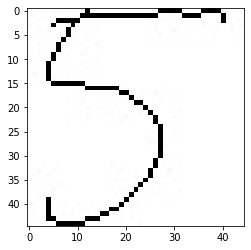

In [32]:
# Test the CNN on real data
# Select the sample
test_im = data[9000]

# Plot
plt.imshow(test_im,cmap = 'gray')

# Reshape to correct dimension
test_im=np.reshape(test_im,[-1,45,45,1])

# Predict the output of the sample
pred = model.predict(test_im)

# Select the highest value
class_prediction = np.amax(pred)

#Get the corresponding index
index_class_pred = find_index(pred[0], class_prediction)
pred = np.argmax(pred, axis=1)
print("predicted name : ", pred[0])

#Image recognition

Resize function to keep the width /height ratio :

In [33]:
# function to resize img keeping the ratio
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

Creation of a function to perform digit and symbol recognition and prediction (using the previous CNN)

It also computes the detected equation at the end of the function and resolve it

In [34]:
def test_handwritten_recognition(img):

# Test of RGB Histogram for the threshold :

    # color = ('b','g','r')
    # for channel,col in enumerate(color):
    #   histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    #   plt.plot(histr,color = col)
    #   plt.xlim([0,256])
    # plt.title('Histogram for color scale picture')
    # plt.show()

    label_array = []

# Obtention of the image shape
    th = img.shape[0]
    tw = img.shape[1]
    print(th, tw)

#----------------------------------------------------------  
# Resize it
    if th > tw:
      img = image_resize(img, height = 800)
    elif th < tw:
      img = image_resize(img, width = 800)

#----------------------------------------------------------
# Bounding box threshold
    lower_h = (0.01*img.shape[1])
    higher_h = (0.5*img.shape[1])
    lower_w = (0.05*img.shape[0])
    higher_w = (0.1*img.shape[0])

#----------------------------------------------------------
# Transform RGB Image to Grayscale

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#-------------------------------------------------------
# Vectorize image to get the n% darkest pixels
    vector_img = np.ravel(img_gray)

#----------------------------------------------------------
#Keep the n% darkest pixels
    value_pxl = np.percentile(vector_img,3)

#----------------------------------------------------------
#Set to black pixels over the threshold and to white pixels under the threshold
    img_gray = np.where(img_gray<value_pxl,0, 255 )
    img_gray = np.array(img_gray, dtype=np.uint8)

#----------------------------------------------------------
#Plot thresholded image
    plt.imshow(img_gray,cmap = 'gray')

#----------------------------------------------------------
#Detect edges
    edged = cv2.Canny(img_gray, 10, 500)

#----------------------------------------------------------
#Find contour : 
#cv2.RETR_EXTERNAL -> only the outer border
#cv2.CHAIN_APPROX_SIMPLE -> only keep the coordinates of the corner of the box

    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = imutils.grab_contours(contours)

#----------------------------------------------------------
#Sort contour in the "reading" way
    contours = sort_contours(contours, method="left-to-right")[0]
    
#----------------------------------------------------------
#Labels
    labels = ['0', '1', '2' ,'3' ,'4', '5' ,'6', '7', '8', '9' ,'div', 'minus' ,'plus', 'times']

#----------------------------------------------------------
#Set previous coordinates to 0
    prev_x = 0
    prev_y = 0
    prev_w = 0
    prev_h = 0    

#----------------------------------------------------------
#Create empty matrix to store bounding box coordinates
    bounding_matrix = np.zeros((len(contours), 4))

#----------------------------------------------------------
#Loop for each countours
    i = 0
    for c in contours:
      
        #Make a rectangle out of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        #Threshold to remove the too small and too big bounding box
        if ((lower_w<=w) and (lower_h<=h<=higher_h)):
          prev_x = x
          prev_y = y
          prev_w = w
          prev_h = h

          #Store into the matrix
          bounding_matrix[i,0] = x
          bounding_matrix[i,1] = y
          bounding_matrix[i,2] = w
          bounding_matrix[i,3] = h

        i = i+1

#----------------------------------------------------------
#Delete rows of 0 (corresponding to those which were not added to the matrix)
    bounding_matrix = bounding_matrix[~np.all(bounding_matrix == 0, axis=1)]

#----------------------------------------------------------
#Add row of zeros to not be out of bounds in the next step
    row = np.array([0,0,0,0])
    bounding_matrix = np.concatenate((bounding_matrix,[row]),axis= 0)

#----------------------------------------------------------
#Deleting the unusable boxes
    new_bounding_matrix = np.zeros((len(bounding_matrix), 4))
  
#----------------------------------------------------------
#Loop over all the elements of the matrix
#Delete overlaping bounding box
    l = 0
    for l in range(0,len(bounding_matrix)):
        for i in range(l+1,len(bounding_matrix)-1):
                   
          l_w = bounding_matrix[l,2]

          if (bounding_matrix[i,0] < (bounding_matrix[l,0] + l_w) and ((bounding_matrix[i,1]+bounding_matrix[i,3]) > (bounding_matrix[l,1]))) : # condition for pwr
            bounding_matrix[i,:] = [0,0,0,0]
            # The previous condition is not sufficient to delete correctly the overlaping bounding box
            #In fact, if a smaller bounding box appears "before" the bounding box we want, it will keep the wrong one

#----------------------------------------------------------
#Delete rows of 0 (corresponding to those which were deleted to the matrix)
    new_bounding_matrix = bounding_matrix
    new_bounding_matrix = new_bounding_matrix[~np.all(new_bounding_matrix == 0, axis=1)]
   
    x_1 = 0
    y_1 = 0
    w_1 = 0
    h_1 = 0

#----------------------------------------------------------
#Loop over the sorted bounding box
    for r in range(0, len(new_bounding_matrix)) :

      pwr = 0

      x = int(new_bounding_matrix[r,0])
      y = int(new_bounding_matrix[r,1])
      w = int(new_bounding_matrix[r,2])
      h = int(new_bounding_matrix[r,3])
      
      #Condition to be a power
      if ((y+h) < (y_1+0.1*h_1)) and (y_1!=0):
        pwr = 1
      
      x_1 = x
      y_1 = y
      w_1 = w
      h_1 = h

#----------------------------------------------------------
#Geting the inside of the bounding box
      roi = img_gray[y:y+h, x:x+w]
      thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

#----------------------------------------------------------
#Store the shape of the image
      (th, tw) = thresh.shape

#----------------------------------------------------------
#Reshape into 45x45 image to feed the CNN
      maxx = max([th, tw, 45])
      dx = int(max(0, maxx - tw)/2.0) +15
      dy = int(max(0, maxx - th) / 2.0) +15
      padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                value=(0, 0, 0))
      padded = cv2.resize(padded, (45, 45))
      
#----------------------------------------------------------
#Invers color, normalize and set correct shape for the CNN
      padded = cv2.bitwise_not(padded)
      padded = padded/255.
      padded = np.expand_dims(padded, axis=0)
      padded = np.expand_dims(padded, axis=-1)

#----------------------------------------------------------
#Prediction of the padded image
      pred = model.predict(padded)
      class_prediction = np.amax(pred)
      index_class_pred = find_index(pred[0], class_prediction)
      pred = np.argmax(pred, axis=1)

#----------------------------------------------------------
#Add to label_array vector the detected labels (in reading order)
      label = labels[pred[0]]
      if pwr == 1 :
         label_array.append('^')
      
      label_array.append(label)

#----------------------------------------------------------
#Draw the boudning box and the label on the image
      cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
      cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

#----------------------------------------------------------
#Plot the image with the boudning box and the labels
    figure = plt.figure(figsize=(20, 20))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#----------------------------------------------------------
#Calculation function to compute the expression given by the label_array vector
    e = ''
    for i in label_array:
        if i=='plus':
            e += '+'
        elif i=='minus':
            e += '-'
        elif i=='times':
            e += '*'
        elif i=='div':
            e += '/'
        elif i=='^':
            e += '**'
        else:
            e += i
    v = eval(e)
    print('Value of the expression {} : {}'.format(e, v))

#Final test

Selection of the images to test and apply the test_handwritten_recognition() function on it :

We have done several test to detect any problematic cases in ordrer to try to solve them

1443 2679


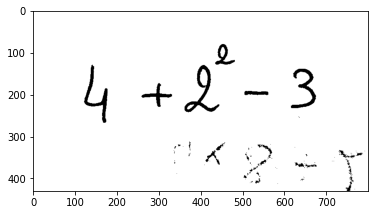

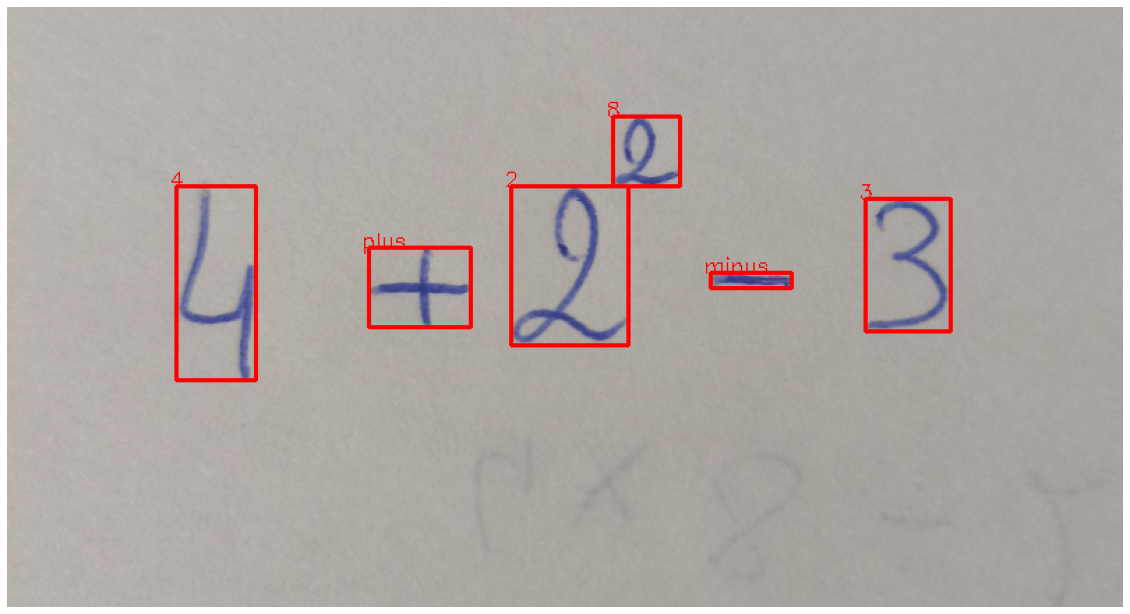

Value of the expression 4+2**8-3 : 257


In [36]:
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/Manual.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/test_vert.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/V.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/B.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/Br.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/R.jpg')
image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/test_eq.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq6.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq7.jpg')#verif
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq8.jpg')# %
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq9.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq10.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq13.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq15.jpg')
# image_to_test = cv2.imread('/content/gdrive/MyDrive/LSMA_Final_Project/Working/eq_test0.jpg')# %



# Handwritten recognition fuction on the image
test_handwritten_recognition(image_to_test)

We can see on this test (realised during our final presentation) that for some of the elements, the detection is not correct:

- First, for the "/" symbol, it is probably slightly too straight to be detected as a "/", it is detected as a "1". We've seen in our EDA that we have a few amount of div samples, hense, it is hardest for our CNN to depict this symbol

- Second, for the others bounding boxes, the problem is probably the bounding box cleaning condition which is not good. In fact the "good" one is probably deleted.

Nevertheless, we tried several tests, trying to "fool" the algorithm using others colors, changing size of the equation and position of the digits (especially for the power ones), changing brightness and adding shadows.

We managed to deal with some of these problems (either automatically or manualy), but there are too many possibilities for us to deal with all of them in this amount of time.

This project was quite challenging for us as we don't have any backgroung in neural network or image recognition due to our scolarship in France. We've learned a lot doing this project, and we would have liked a bit more time to go deeper in the project.